## A/B testing: Evaluating a modification to your system

In [1]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from e4e import E4E

e4e = E4E(chapter=2)

### Run ad hoc experiment

#### Simulate trading system

In the simulated trading system, we assume that we know the expectation of the execution cost of the two options of exchanges and that both options in the A/B testing procedure are normally distributed. We know that option A has a higher expected execution cost but because there is variation (uncertainty) in the execution cost, sometimes option B actually has a higher execution cost. As such, we need multiple data points, and we average over them as a way of recovering the expected excecution costs for comparison. Replication can thus be used to combat variation.

In [2]:
# Simulate trading system
def trading_system(exchange):
    if exchange == "ASDAQ":
        execution_cost = 12         # the expectation of trading cost on ASDAQ is 12
    elif exchange == "BYSE":
        execution_cost = 10         # the expectation of trading cost on BYSE is 10
    execution_cost += np.random.normal()    # randomness represent factors that might change from trade to trade
    return execution_cost

In [3]:
# try out the simulator
np.random.seed(17)              
trading_system("ASDAQ")

12.27626589002132

In [4]:
# comparing execution costs of each exchange
np.random.seed(17)                          # for this seed ASDAQ > BYSE
print(trading_system("ASDAQ"))
print(trading_system("BYSE"))

12.27626589002132
8.145371921193496


In [5]:
np.random.seed(18)                          # for this seed BYSE > ASDAQ
print(trading_system("ASDAQ"))
print(trading_system("BYSE"))

12.079428443806204
12.190202357414222


#### Variation

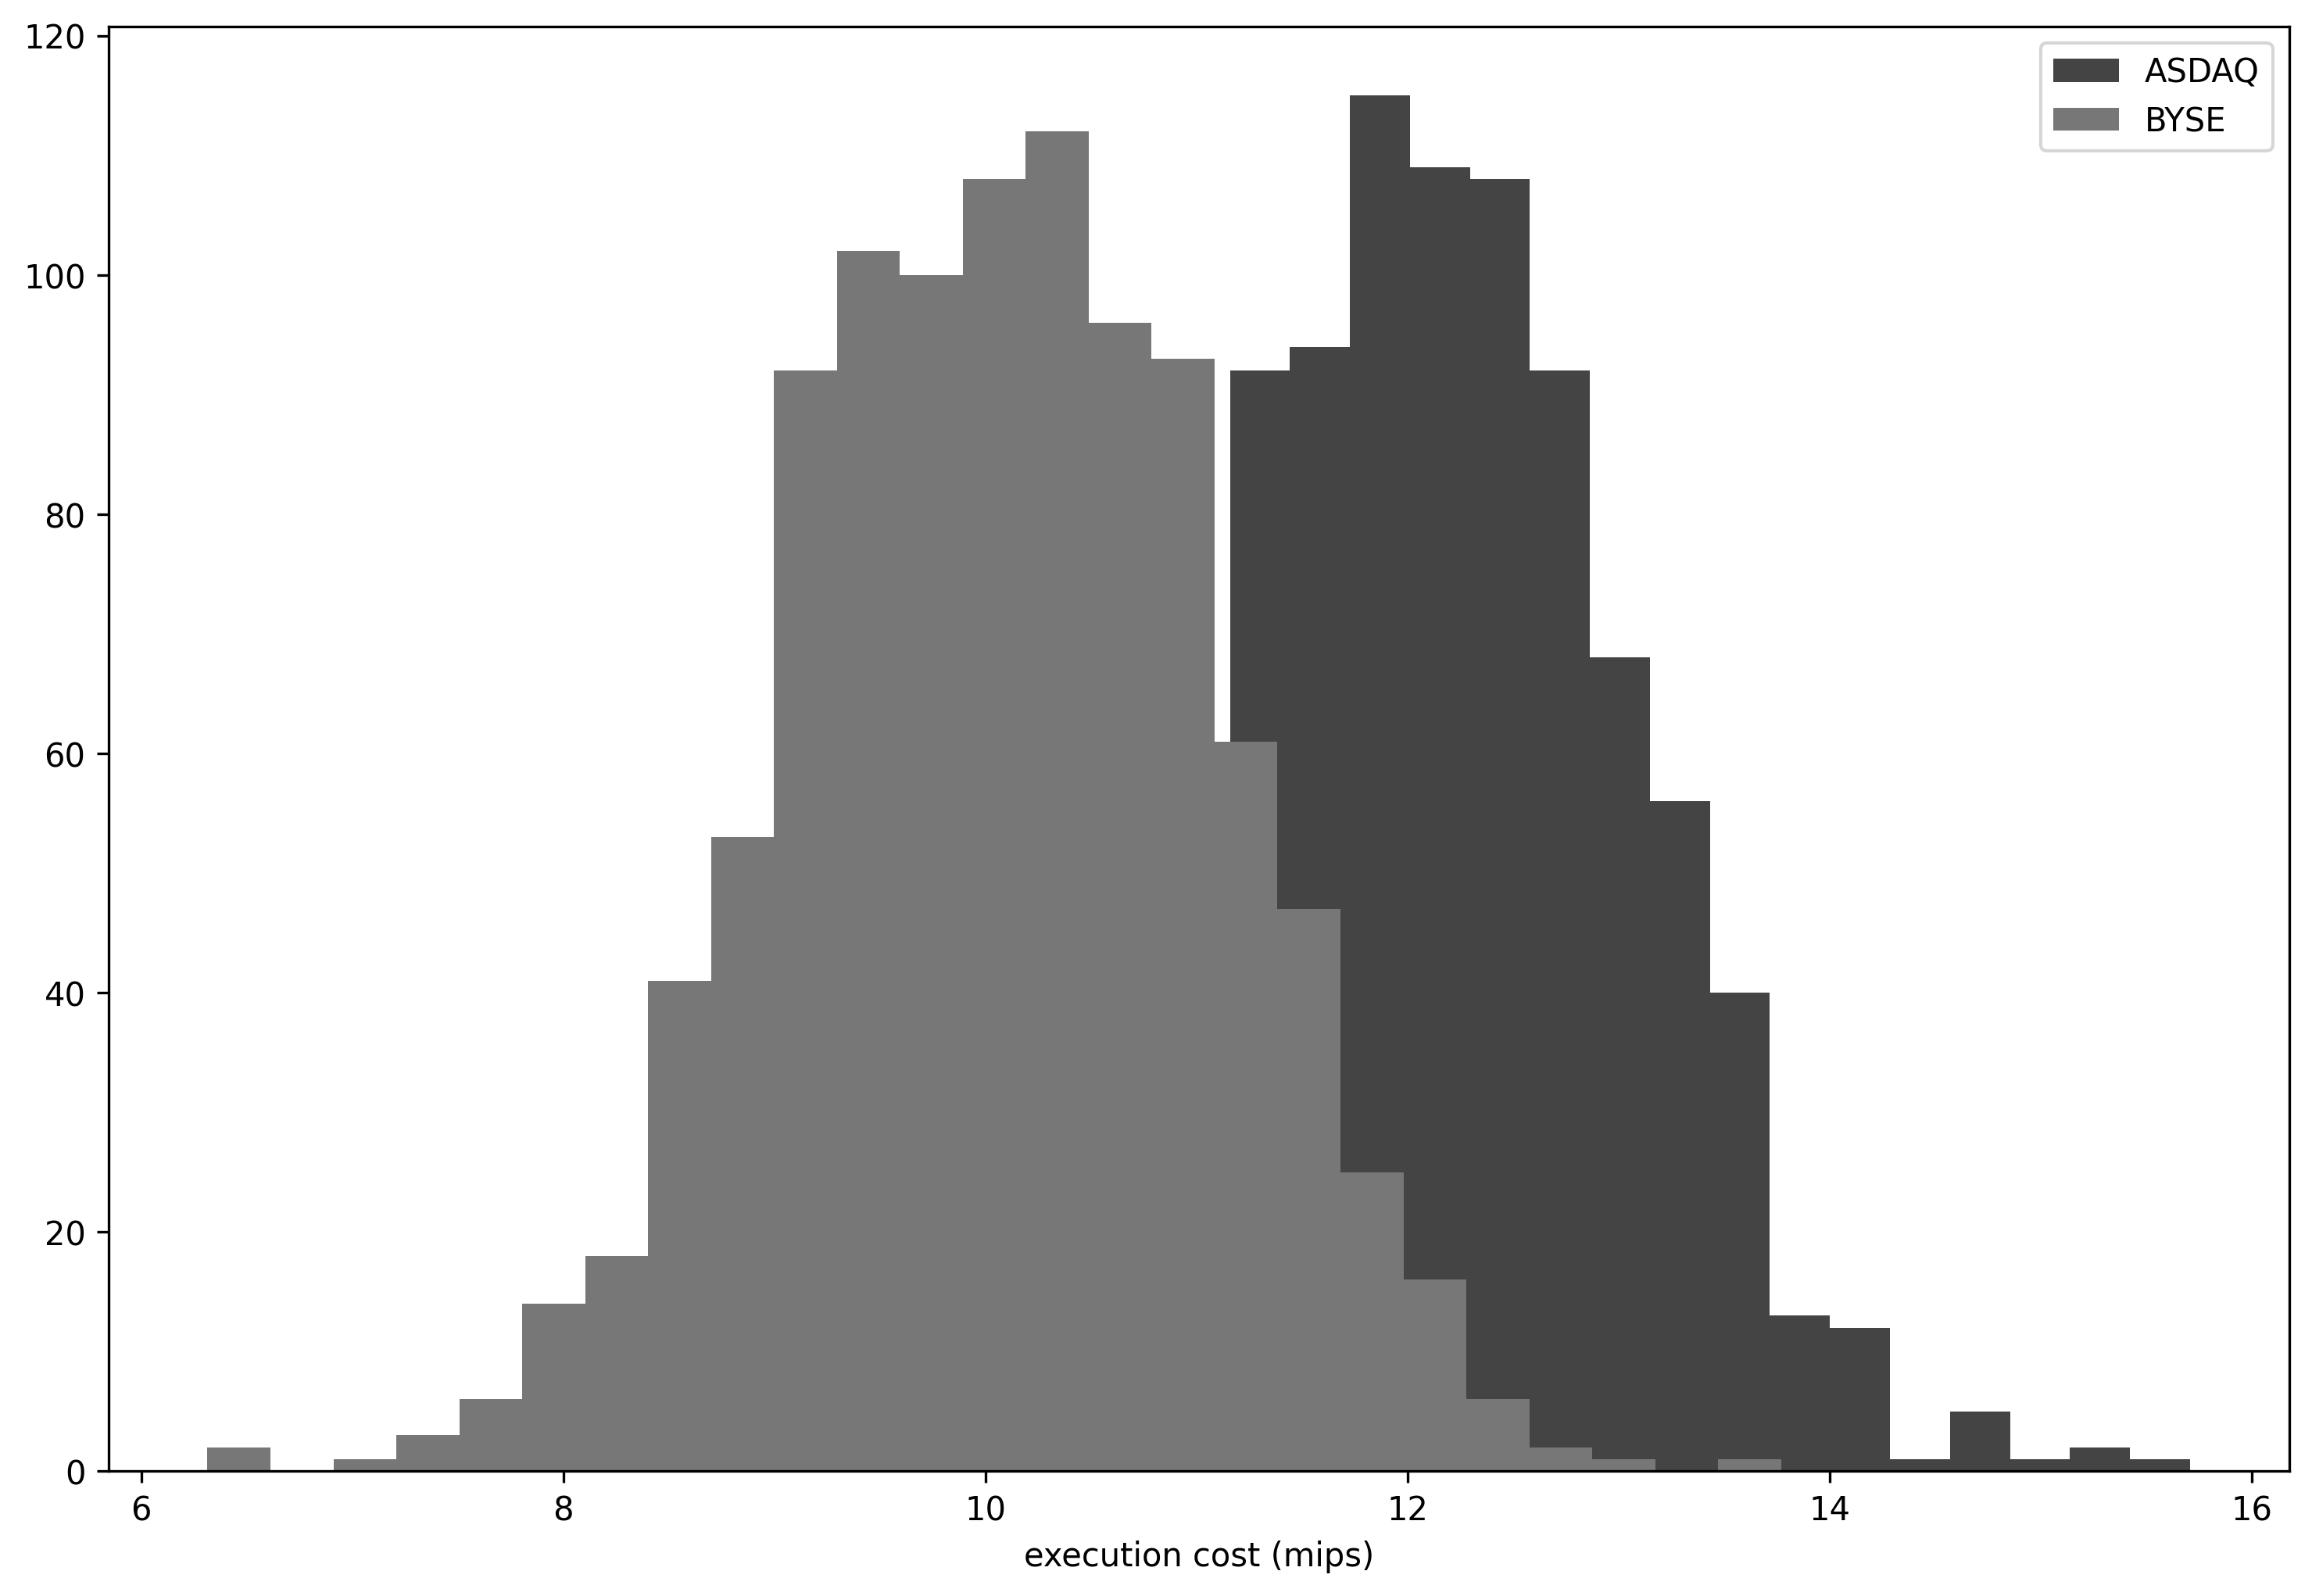

In [6]:
np.random.seed(17)
a = np.array([trading_system("ASDAQ") for _ in range(1000)]) # generate data for option A in A/B testing
b = np.array([trading_system("BYSE") for _ in range(1000)])  # generate data for option B in A/B testing
plt.figure(figsize=(12,8))
plt.hist(a, 25, color=e4e.color_1)      # distribution of option A
plt.hist(b, 25, color=e4e.color_2)      # distribution of option B
plt.legend(["ASDAQ", "BYSE"])
plt.xlabel("execution cost (mips)")
plt.show()

In [7]:
i = np.where(b < a)[0]  # indices for which condition is true. ndarray is in tuple so index [0]
len(i) / len(b)         # byse is generally less than asdaq

0.911

In [8]:
# replication by averaging over multiple measurements to combat variation (increase reliability of decision) 
np.random.seed(17)
print(np.round(np.array([trading_system("ASDAQ") for _ in range(1000)]).mean(),2))
print(np.round(np.array([trading_system("BYSE") for _ in range(1000)]).mean(),2))


12.02
10.07


In [9]:
print(np.round(np.array([trading_system("ASDAQ") for _ in range(1000)]).mean(),2))
print(np.round(np.array([trading_system("BYSE") for _ in range(1000)]).mean(),2))

11.96
10.06


#### Bias

Bias refers to conditions that consistently yield different results. In the trading system, trades in the morning consistently results in a higher execution cost no matter the exchange used. The increase in the execution costs when trading in the morning is captured in the bias. So suppose we consistently use one exchange in the morning and the other in the afternoon, this becomes a case of confounder bias, because the biasing variable is consistently affecting the option chosen (treatment) and the outcome. The way to combat confounder bias is randomization.

In [10]:
# A simulator that accounts for time of day
def trading_system_tod(exchange, time_of_day):
    if time_of_day == "morning":                # bias is conditions that consistently yield different results
        bias = 2.5                              
    elif time_of_day == "afternoon":            # cost is lower in the afternoon
        bias = 0
    return bias + trading_system(exchange)      # cost is still a function of exchange

In [11]:
# sampling bias - taking measurement (sampling) under different conditions consistently yields different results
np.random.seed(17)
print(np.round(np.array([trading_system_tod("ASDAQ", "morning") for _ in range(100)]).mean(),2))
print(np.round(np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(100)]).mean(),2))

14.61
12.01


In [12]:
# confounder bias - apply a bias differently and consistently to two versions of the system being compared
np.random.seed(17) # due to confounder bias option B looks to have a higher execution cost than option A
print(np.round(np.array([trading_system_tod("BYSE", "morning") for _ in range(100)]).mean(),2))
print(np.round(np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(100)]).mean(),2))

12.61
12.01


In [13]:
# confounder bias is persistent
np.random.seed(17) # due to confounder bias option B looks to have a higher execution cost than option A
print(np.round(np.array([trading_system_tod("BYSE", "morning") for _ in range(1000)]).mean(),2))
print(np.round(np.array([trading_system_tod("ASDAQ", "afternoon") for _ in range(1000)]).mean(),2))

12.52
12.07


In [14]:
# combat confounder bias using randomization
def randomized_measurement():
    asdaq_measurement = []
    byse_measurement = []
    for tod in ["morning", "afternoon"]: # make 1000 trades in the morning, 1000 trades in the afternoon
        for _ in range(1000):  # whether morning or afternoon we randomly choose the exchange to use
            if np.random.randint(2) == 0: # flip a coin using discrete uniform distribution in [0,2)
                asdaq_measurement.append(trading_system_tod("ASDAQ", tod))  # randomly choose option A
            else:
                byse_measurement.append(trading_system_tod("BYSE", tod))    # randomly choose option B
    return (np.round(np.array(asdaq_measurement).mean(), 2),    # option A using randomization
            np.round(np.array(byse_measurement).mean(), 2))     # option B using randomization

In [15]:
np.random.seed(17)
randomized_measurement()  # after randomization, option A has a higher execution cost than option B

(13.26, 11.26)

In [16]:
# Randomization removes the time of day confounding bias and its result is persistent
print(randomized_measurement())
print(randomized_measurement())
print(randomized_measurement())
print(randomized_measurement())
print(randomized_measurement())

(13.22, 11.31)
(13.21, 11.28)
(13.28, 11.27)
(13.28, 11.24)
(13.3, 11.24)


### Take precise measurement

#### Mitigate measurement variation with replication

The same way we use replication to combat variation, we can use replication to improve the precision of the estimated expectation. This distribution is the distribution of the sample means, where we take a sample of replicated measurements multiple times, and each time we calculate the sample mean. We can improve the precision of the sample means by increasing the sample size. For the same number of repeatitions, an increase in sample size means we are increasing the number of samples tested overall. Thus for two options, A and B, if we take repeated sample means we increase the precision of the estimated expectations, and therefore more clearly see which option is better.

In [17]:
np.random.seed(17)
measurements = np.array([trading_system("ASDAQ") for _ in range(3)])
print(measurements)

[12.27626589 10.14537192 12.62390111]


In [18]:
# aggregated measurement is closer to expectation ie coded into trading_system(), here 12
np.round(measurements.mean(),2) 

11.68

In [19]:
# computing deviations of individual measurment
print(measurements - 12)

[ 0.27626589 -1.85462808  0.62390111]


In [20]:
# computing deviation of aggregated measurement
print(np.round(measurements.mean() - 12, 2))

-0.32


In [21]:
# computing standard deviation using expectation from histogram
np.round(np.sqrt(((measurements - 12) ** 2).mean()),2)

1.14

In [22]:
# computing standard deviation with aggregated measurement mean
np.round(np.sqrt(((measurements - measurements.mean()) ** 2).mean()),2)

1.1

In [23]:
# using NumPy's inbuilt standard deviation function
np.round(measurements.std(),2)

1.1

In [24]:
# Aggregate measurement
def aggregate_measurement(exchange, num_individual_measurements):
    individual_measurements = np.array(                 # convert to NumPy array to use .mean() NumPy method
        [trading_system(exchange)                                   
        for _ in range(num_individual_measurements)]    # take individual measurement multiple times
    )
    return individual_measurements.mean()               # average individual measurement

(8.24469883558743, 16.062847309770497, 0.0, 298.2)


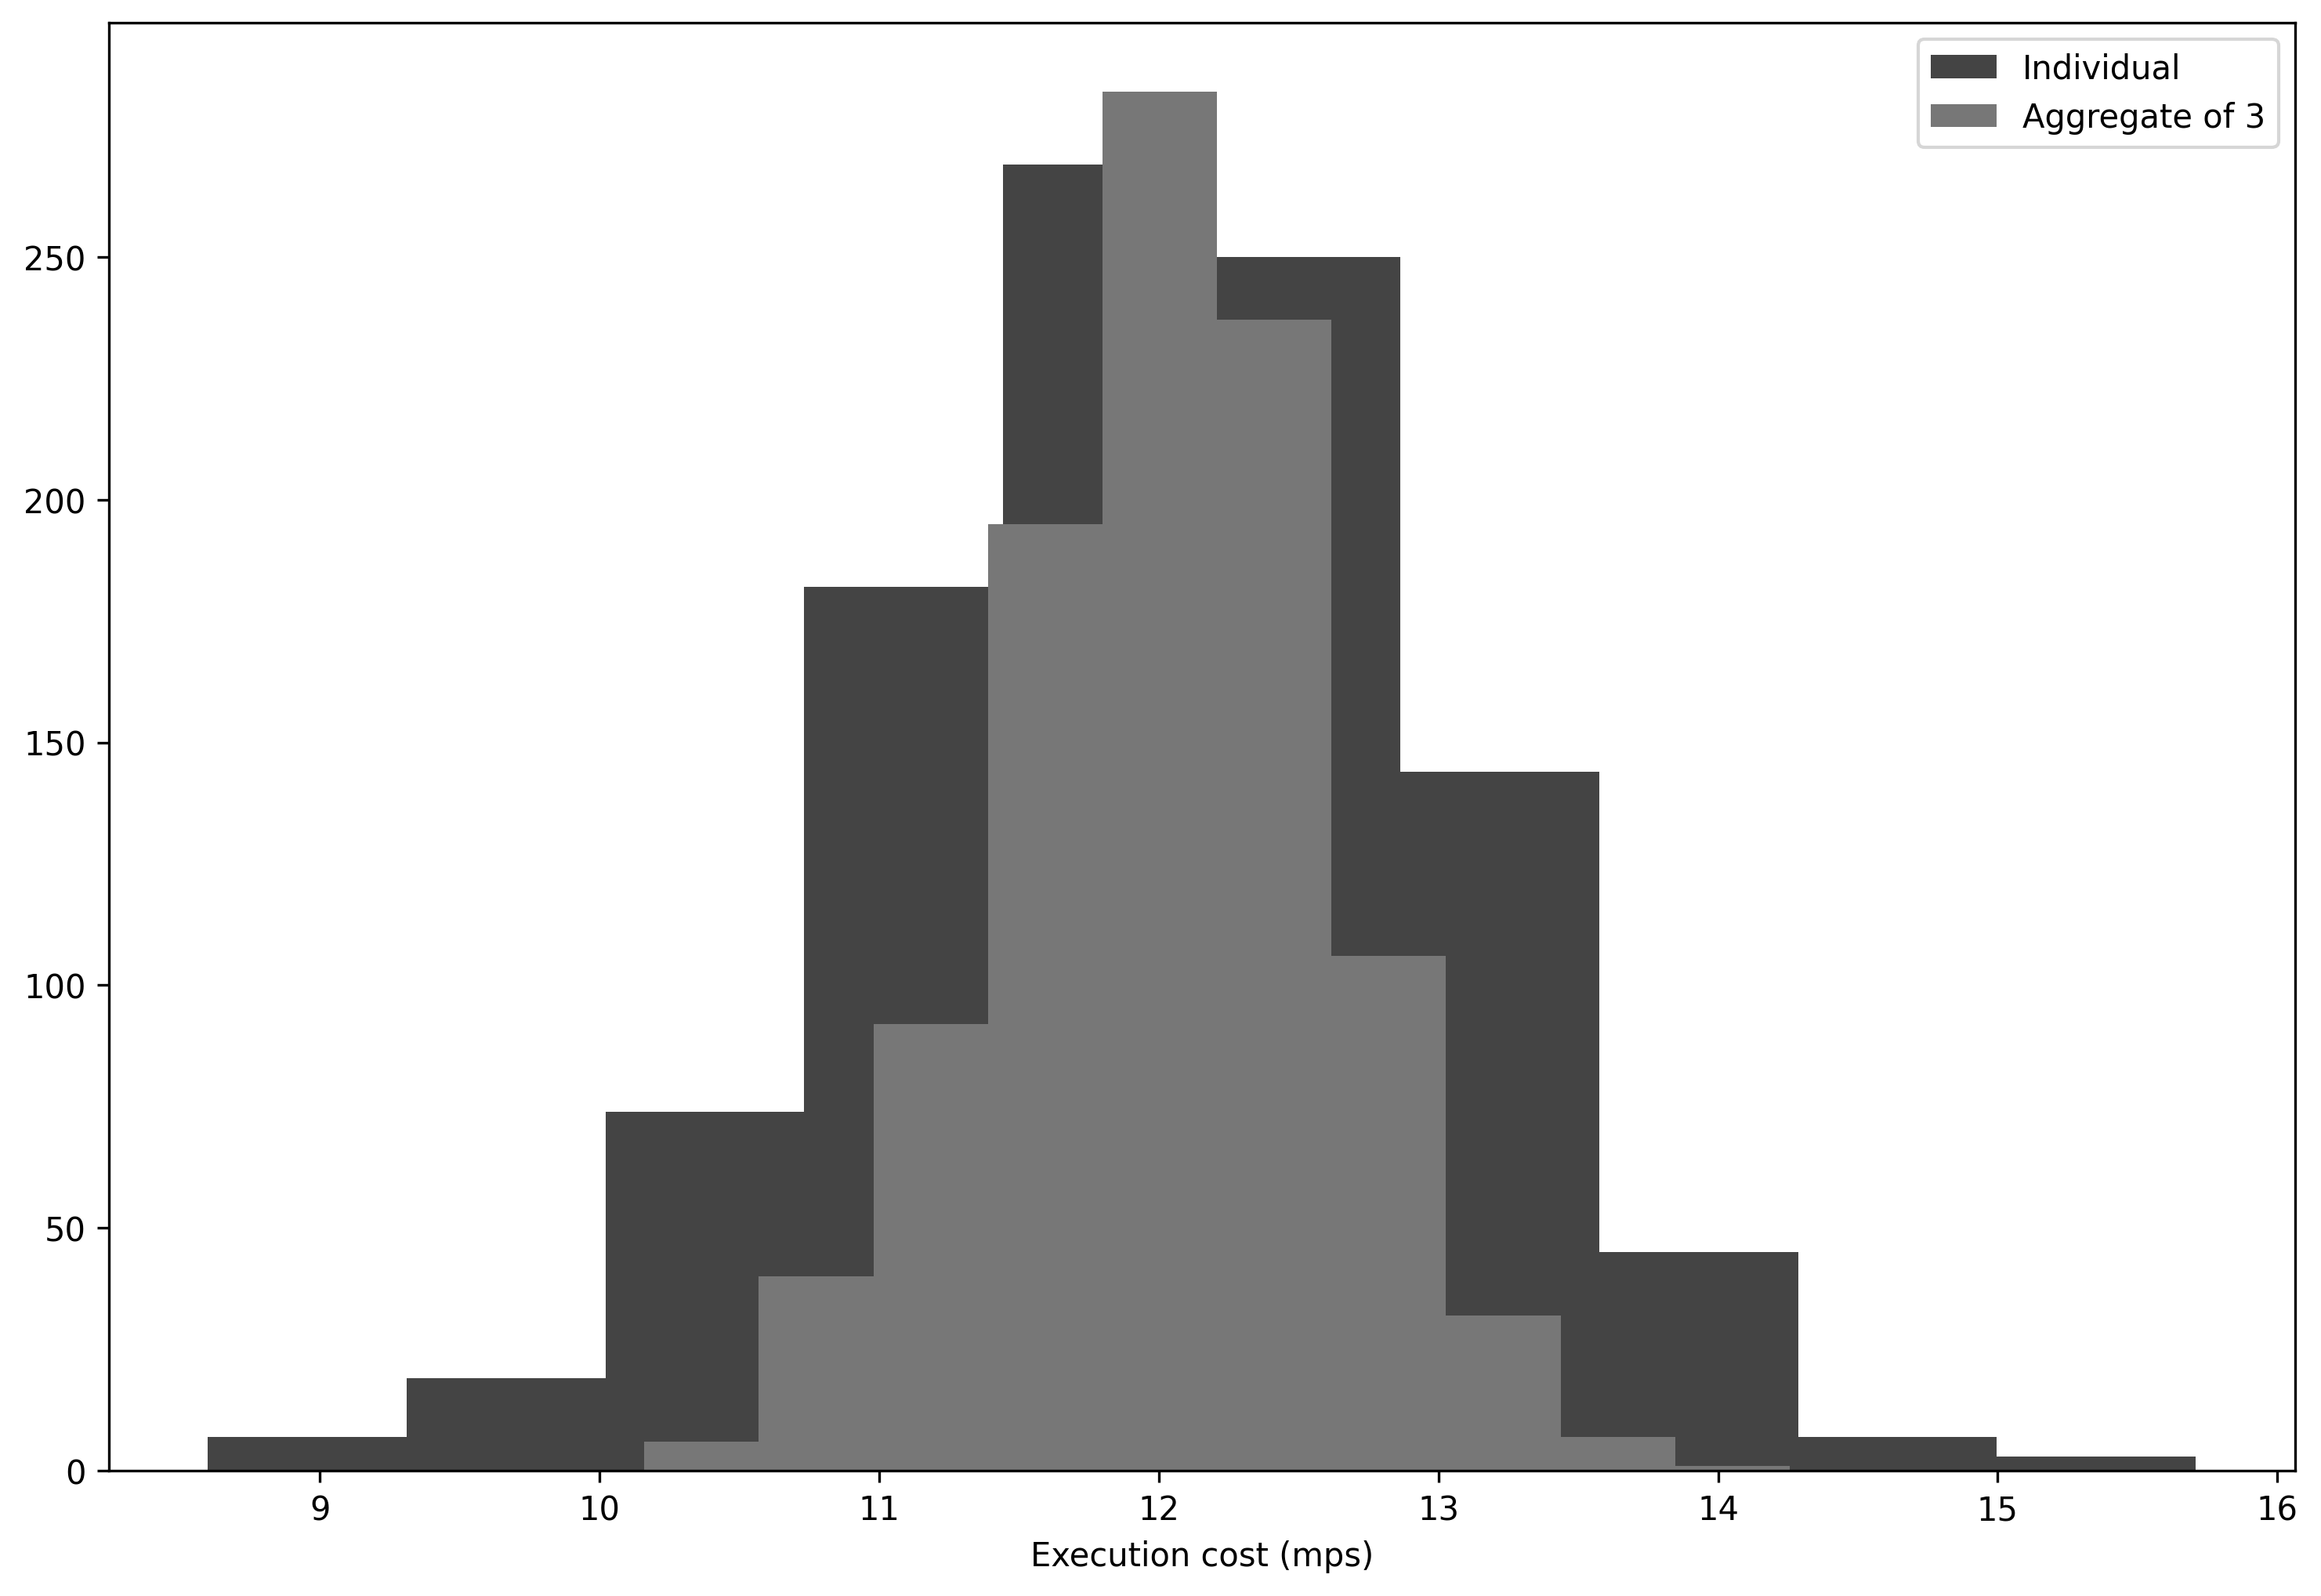

In [25]:
# Aggregate measurement vs Individual measurement distribution
plt.figure(figsize=(12,8))
plt.hist(np.array([trading_system("ASDAQ") for _ in range(1000)]), color=e4e.color_1) # sample distibution
plt.hist(   # sample means distribution
    np.array([aggregate_measurement("ASDAQ",3) for _ in range(1000)]), color=e4e.color_2
)
plt.xlabel("Execution cost (mps)")
print(plt.axis())                               # [xmin, xmax, ymin, ymax]
plt.legend(["Individual", "Aggregate of 3"])
plt.show()

(7.90011272546129, 15.87033202979699, 0.0, 286.65)


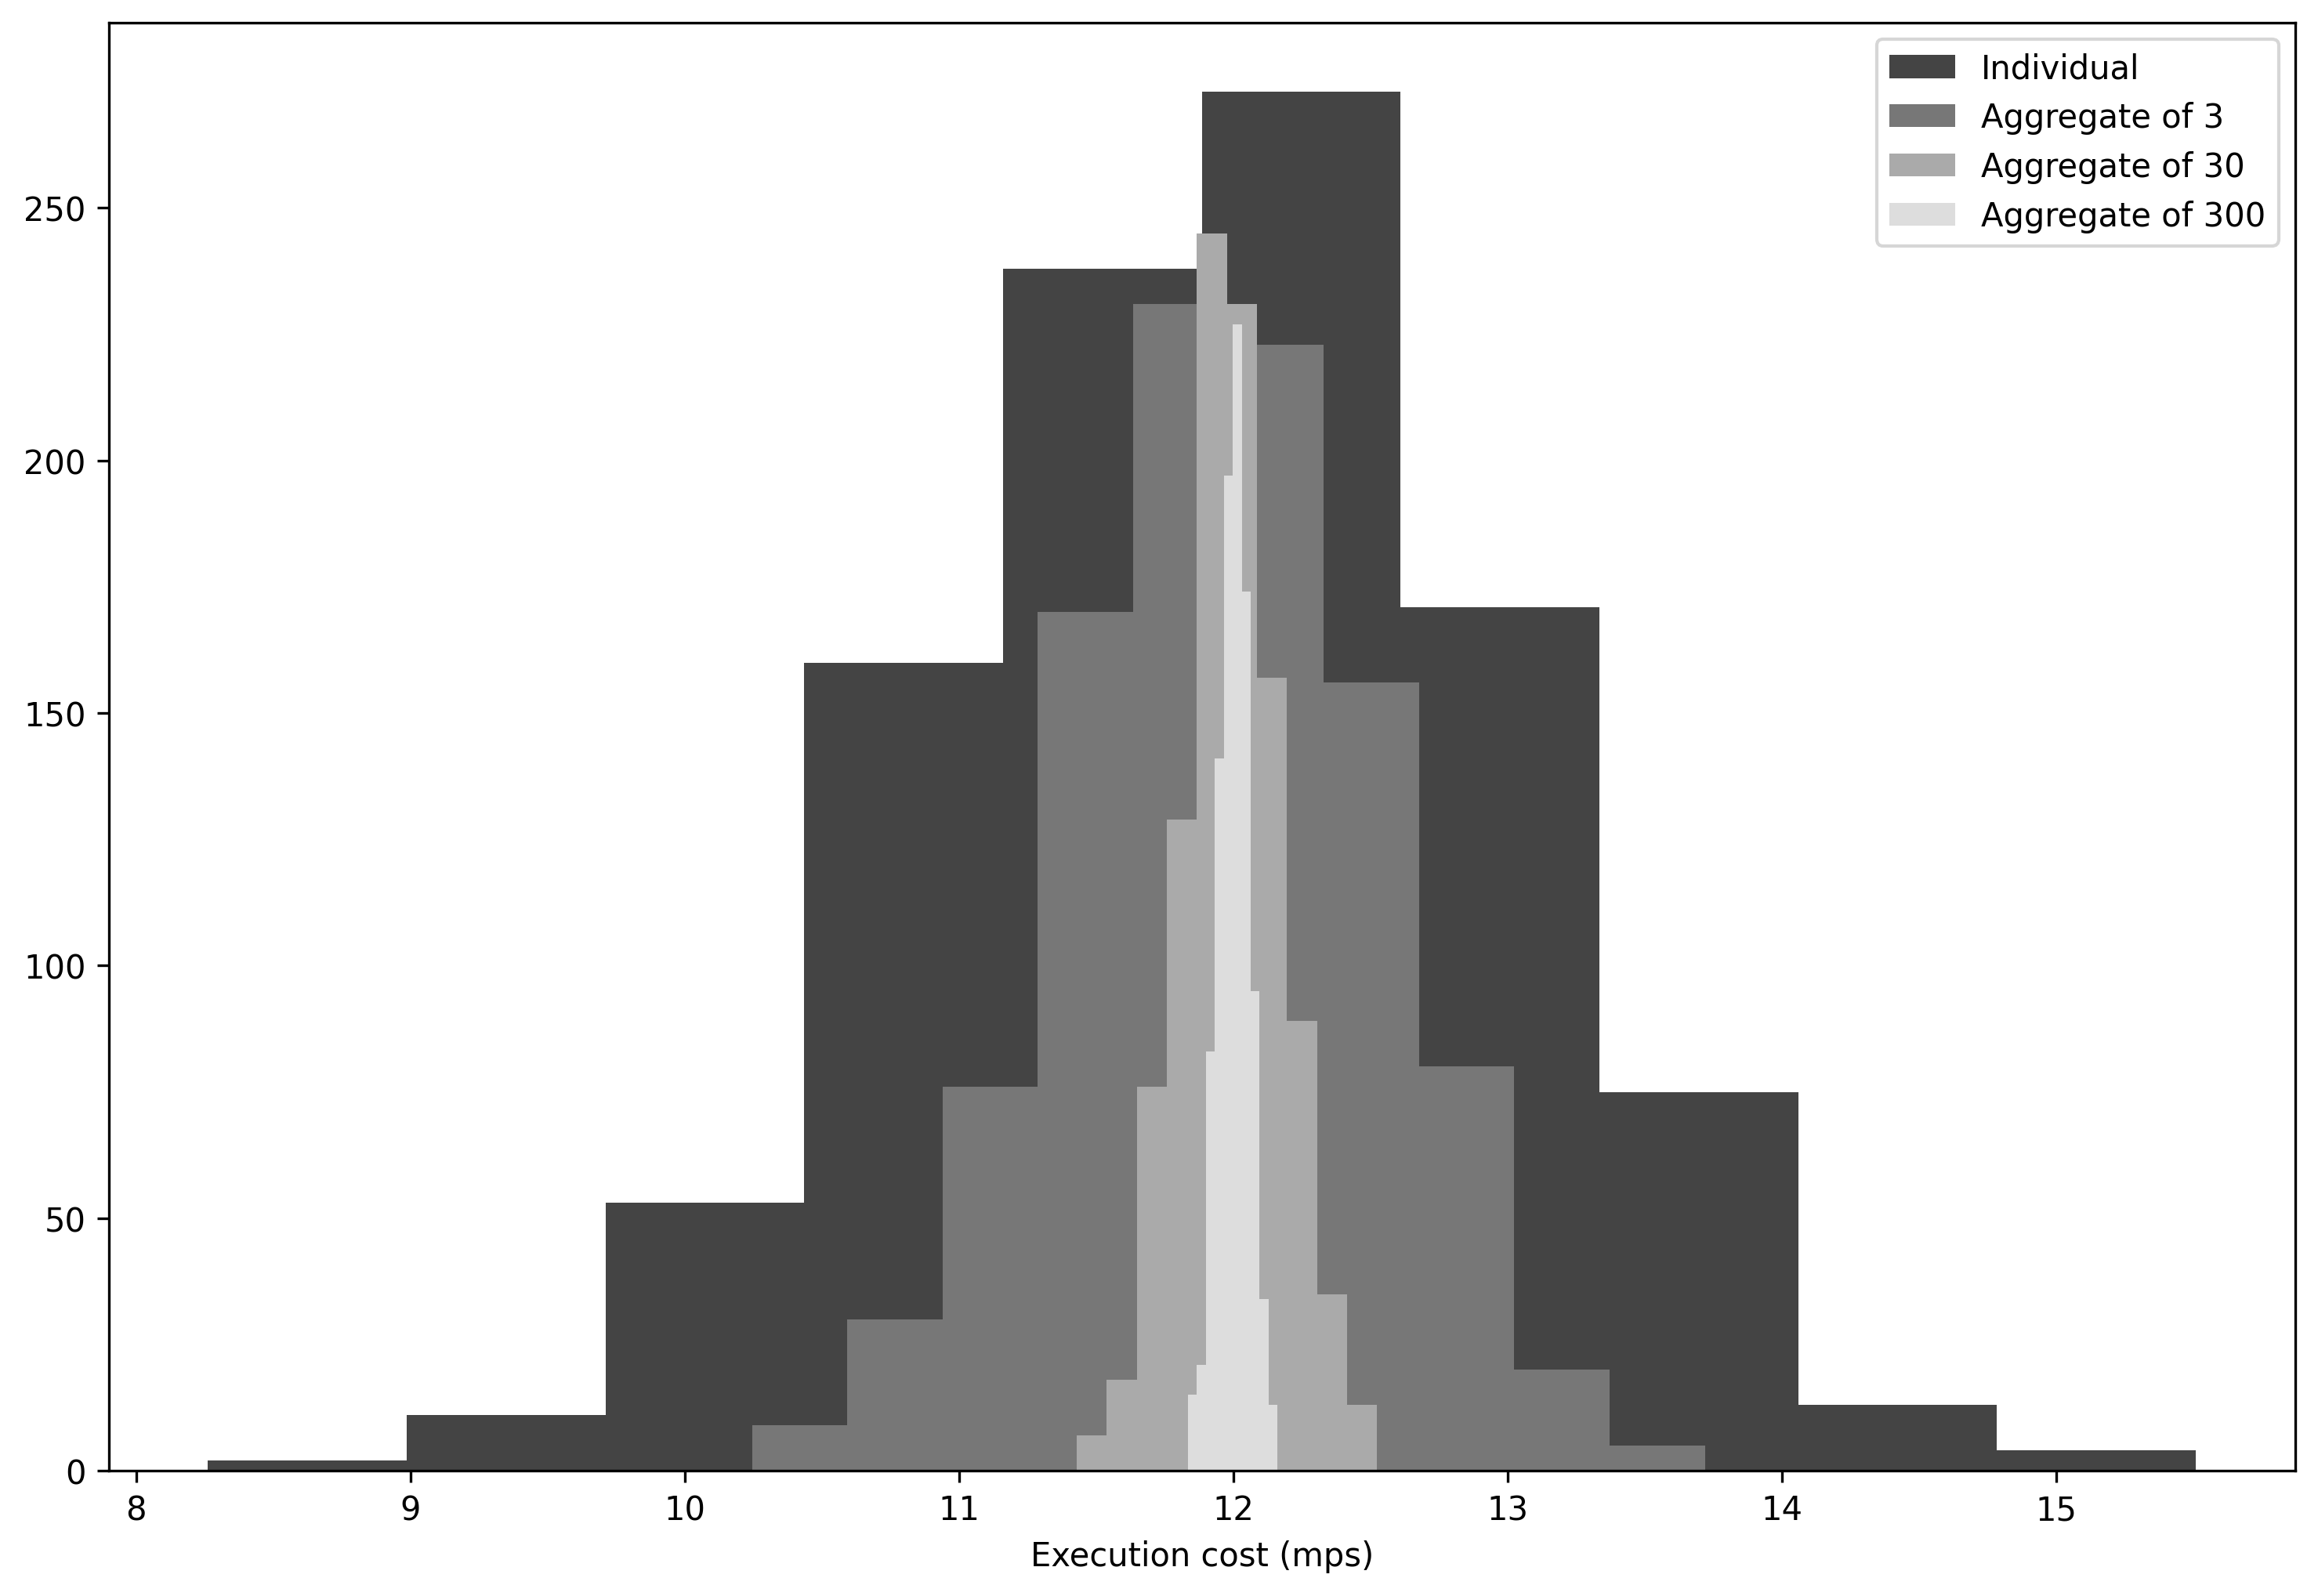

In [26]:
# Improving the precision of aggregate measurements
plt.figure(figsize=(12,8))
plt.hist(np.array([trading_system("ASDAQ") for _ in range(1000)]), color=e4e.color_1)
plt.hist(
    np.array([aggregate_measurement("ASDAQ",3) for _ in range(1000)]), color=e4e.color_2
)
plt.hist(
    np.array([aggregate_measurement("ASDAQ",30) for _ in range(1000)]), color=e4e.color_3
)
plt.hist(
    np.array([aggregate_measurement("ASDAQ",300) for _ in range(1000)]), color=e4e.color_4
)
plt.xlabel("Execution cost (mps)")
print(plt.axis())                               # [xmin, xmax, ymin, ymax]
plt.legend(["Individual", "Aggregate of 3", "Aggregate of 30", "Aggregate of 300"])
plt.show()

In [27]:
# comparing precision of aggregate measurements
np.random.seed(17)
print(aggregate_measurement("ASDAQ", 300))
print(aggregate_measurement("BYSE", 300))

12.000257642551059
10.051095649188758


In [28]:
print(aggregate_measurement("ASDAQ", 300))
print(aggregate_measurement("BYSE", 300))

11.987318214094266
10.021053044438455


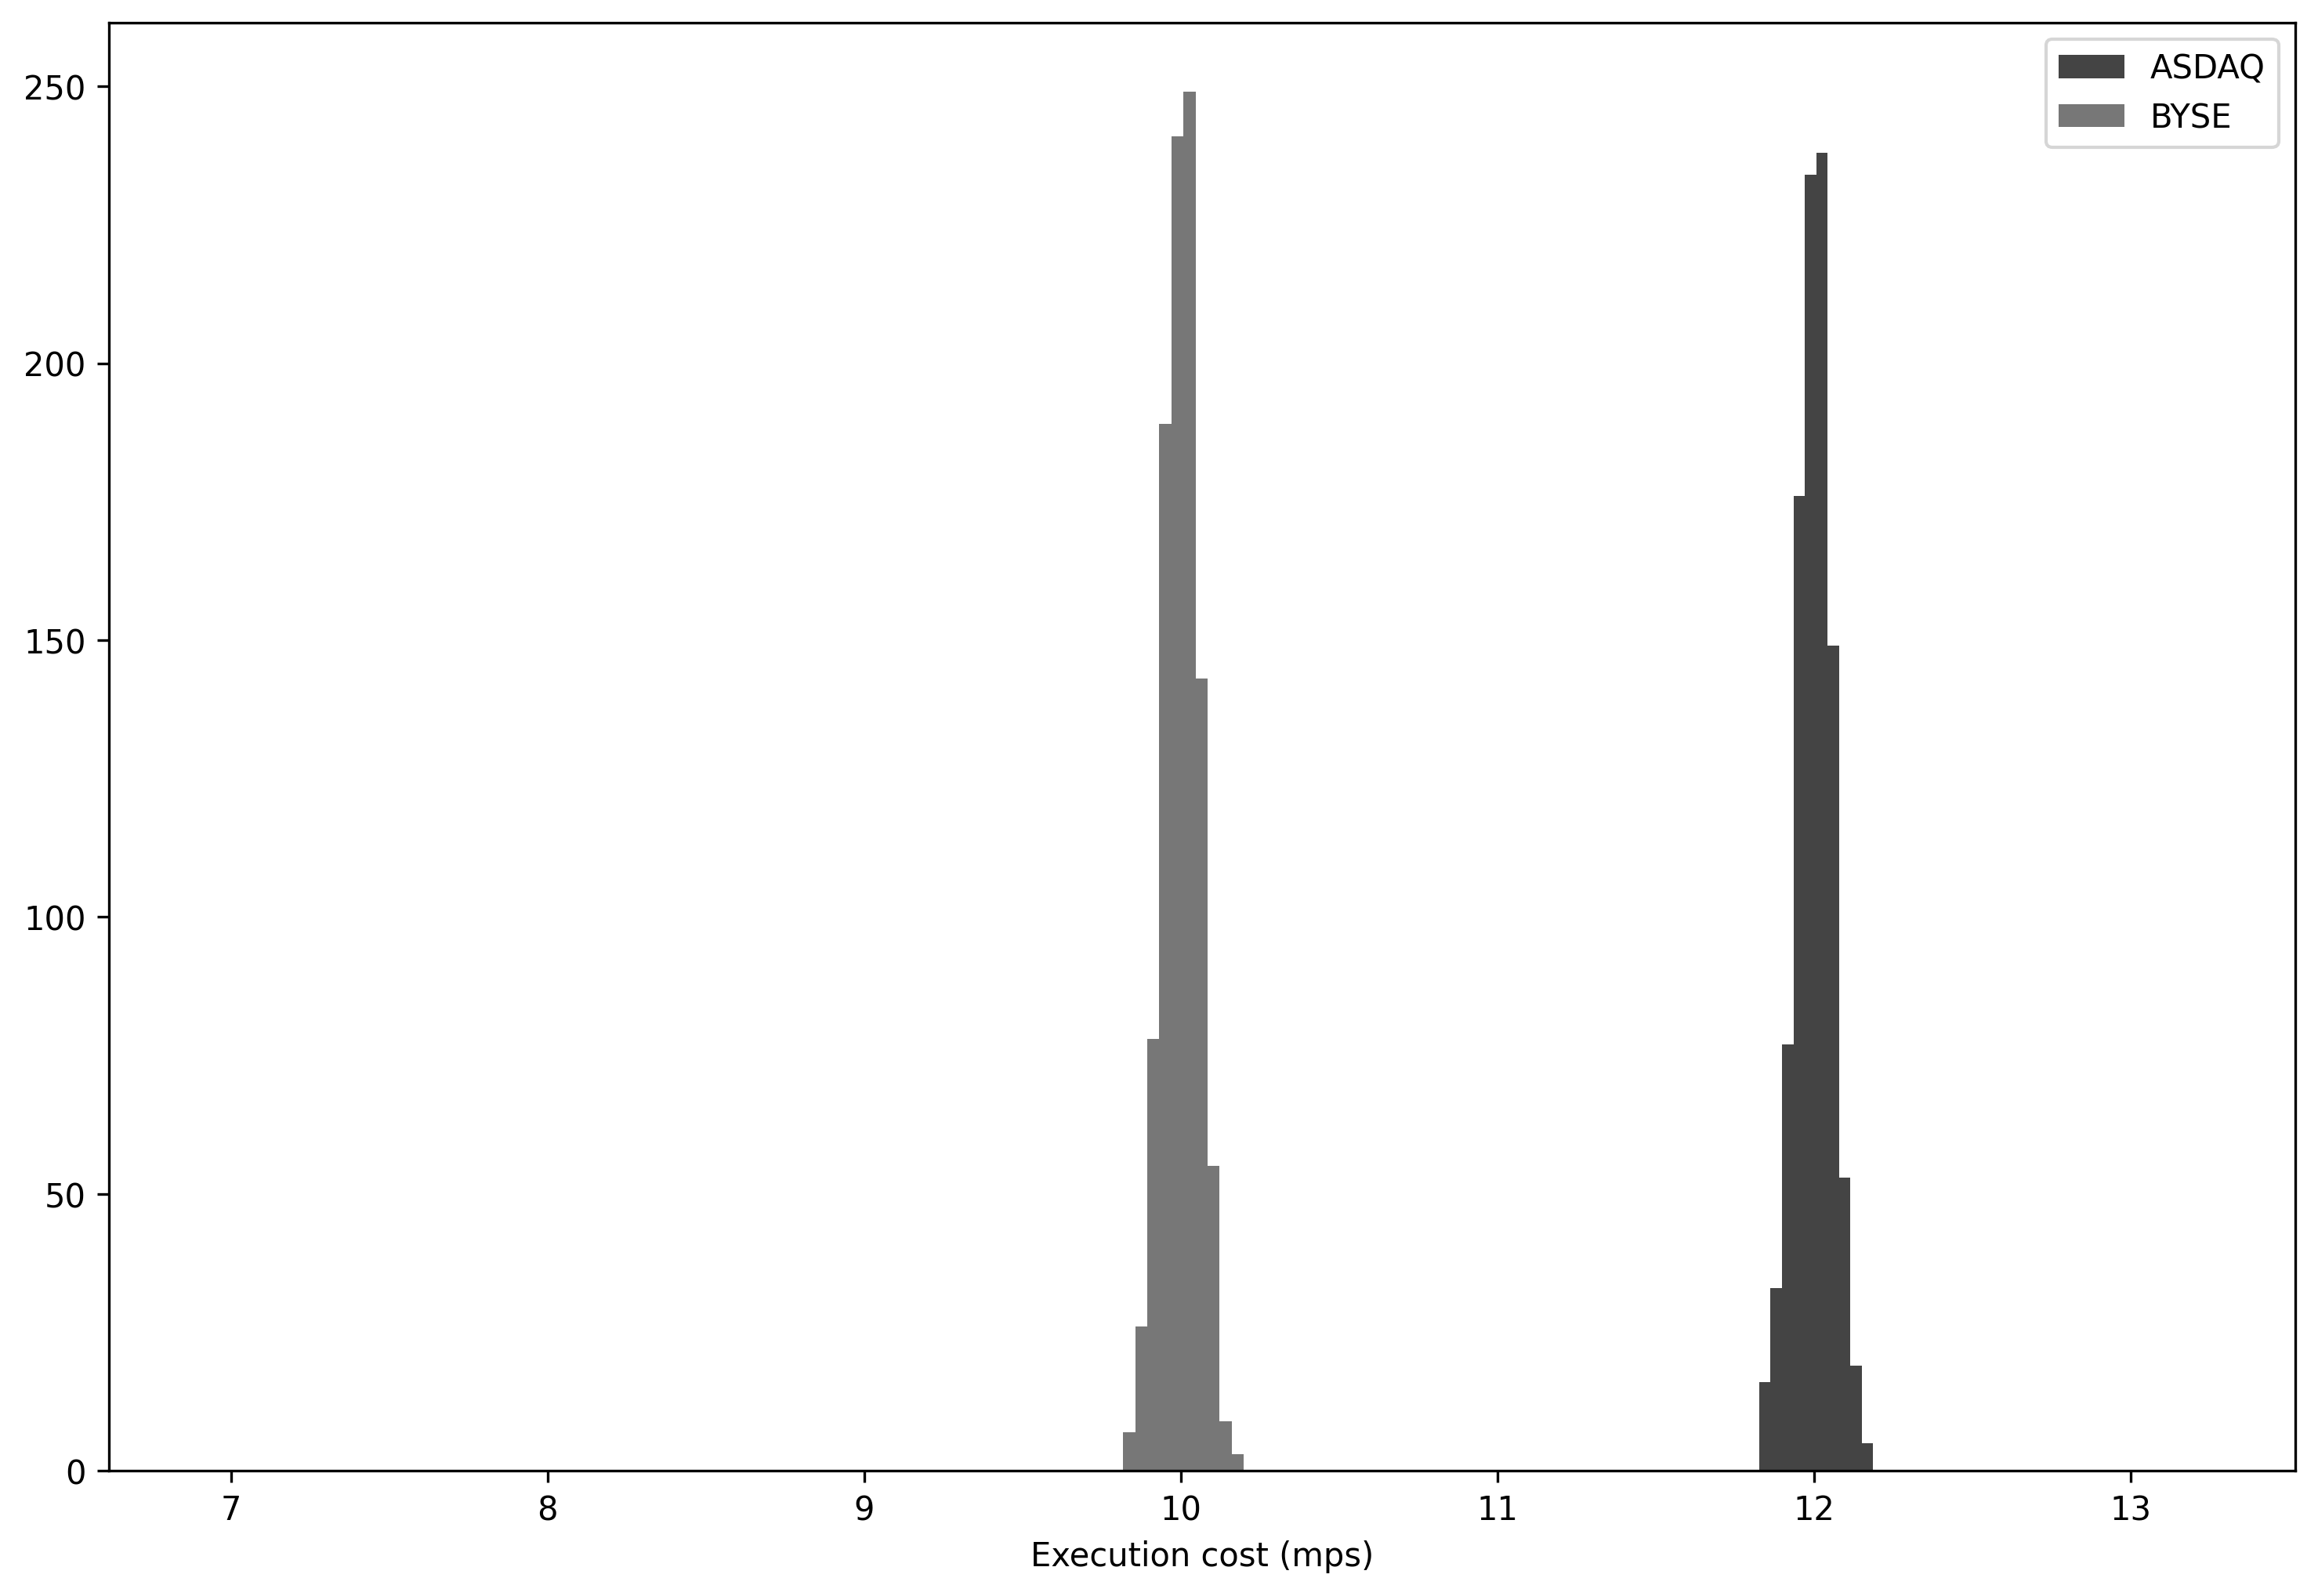

In [29]:
plt.figure(figsize=(12,8))
plt.hist(
    np.array([aggregate_measurement("ASDAQ", 300) for _ in range(1000)]), color=e4e.color_1
)
plt.hist(
    np.array([aggregate_measurement("BYSE", 300) for _ in range(1000)]), color=e4e.color_2
)

c = plt.axis()  # store matplotlib's original xmin, xmax, ymin, ymax
plt.axis([6.614, 13.52, c[2], c[3]])
plt.xlabel("Execution cost (mps)")
plt.legend(["ASDAQ", "BYSE"])
plt.show()

#### Standard Error

The standard error gives how far an aggregate measurement is from the true measurement. If we have a bunch of repeated aggregated measurements, the standard error would be the standard deviation of the aggregate measurements. Typically, the result of our experiment will be a single aggregate measurement, which is obtained from the individual measurements. Even so, we are able to estimate the standard error from the standard deviation ($\sigma$) and the size ($N$) of the individual measurements as follows:

$SE$ = $\frac{\sigma}{\sqrt N}$

The standard error allows us to estimate the distribution of sample means from a single sample.

In [30]:
np.random.seed(17)
agg_3 = np.array([aggregate_measurement("ASDAQ", 3) for _ in range(1000)] )
agg_30 = np.array([aggregate_measurement("ASDAQ", 30) for _ in range(1000)] )
agg_300 = np.array([aggregate_measurement("ASDAQ", 300)for _ in range(1000)] )

In [31]:
print(agg_3.std(), agg_30.std(), agg_300.std()) # standard error of differen sample sizes

0.5721786019484487 0.18071680926647696 0.05808839858239513


In [32]:
# Aggregate measurement with SE
def aggregate_measurement_with_se(exchange, num_individual_measurements):
    individual_measurements = np.array(
        [trading_system(exchange) for _ in range(num_individual_measurements)]
    )                                                           # collect individual measurements
    aggregate_measurement = individual_measurements.mean()      # calculate aggregate measurement
    sd_1 = individual_measurements.std()                    # standard deviation of individual measurements
    se = sd_1 / np.sqrt(num_individual_measurements)        # calculate standard error of aggregate measurement
    return aggregate_measurement, se                        # estimated expectation and standard error

In [33]:
np.random.seed(17)
print(aggregate_measurement_with_se("ASDAQ", 300))
print(aggregate_measurement_with_se("BYSE", 30))

(12.000257642551059, 0.060254756364981225)
(10.078682892915477, 0.13362520254276)


### Run an A/B test

Given delta, $\delta$, to be the difference between the estimated expectations for options A and B, and the standard error, we can convert the delta, $\delta$, value to standard normal for statistical significance calculations. The null hypoethesis states that $\delta$ is zero, so assuming the null hypothesis is true,
the mean of the delta distribution is zero. Since the distribution of the deltas is based on aggregates, we talk of the standard error of the deltas . Therefore given a delta value computed from aggregates and the standard error of the delta values, the z-score is as follows:

$z=\frac{\delta}{se_{\delta}}$

The standard error of delta is obtained from the standard errors of options A and B due to the fact that the variance of the result of adding / subtracting two independent distributions is the sum of the individual distributions' variances. Therefore since delta is $B-A$,  the standard error of delta is related to the standard errors of A and B distributions as follows:

$se_{\delta}=\sqrt {se_A^2 + se_B^2}$

The z-score of the  delta measurement can then be compared to the standard normal distribution to see if its statistically significant. Typically, a statistical significance level of less than or equal to 0.05 ie 5% is used, representing a less than 5% chance of a false positive.

The standard error of any aggregate measurement can be expressed in terms of the standard deviation of the underlying distriubtion and the sample size. The standard error of the delta can also be expressed in terms of the standard deviation of the delta. Standard error denotes deltas between aggregate measurements and standard deviation denotes deltas between individual measurements. :



$se_{\delta}=\frac{sd_{\delta}}{\sqrt n}$ 

$sd_{\delta}=\sqrt {sd_A^2 + sd_B^2}$

$se_{\delta}=\frac{sd_{\delta}}{\sqrt n}$

$z = \frac{\delta*\sqrt{n}}{sd_{\delta}}$

$n={(\frac{z*sd_{\delta}}{\delta})}^2$

Now suppose that we assume that option B differs from option A in expectation only, but the standard deviations are the same, then we can simplify the expression for the standard deviation of the delta.

$sd_{\delta}=\sqrt {2*sd_A^2}$

$sd_{\delta}=\sqrt {2}*sd_A$

$n={(\frac{z*\sqrt {2}*sd_A}{\delta})}^2$

$n={(\frac{z*\sqrt {2}*sd_A}{\delta})}^2$

$n={2*(\frac{z*sd_A}{\delta})}^2$



The last substitution is to focus on the meaning of $\delta$ as the measure of improvement, so instead of a simple increase in count, we can divide by the original option A value to get the percentage increase. We call this the practical significance. So given a particular significance value for delta, the number needed for each option is:

$n={2*(\frac{z*sd_A}{prac\_sig})}^2$

$n={2*z^2*(\frac{sd_A^2}{prac\_sig^2})}$

$n={z^2*(\frac{var_A}{prac\_sig^2})}$

Which ever way a $delta$ value is defined depends on the industry, but has the same meaning (measure of change) and role in the formula above. In the exchange rate example, delta is defined as the differences in cost. As such the null hypthesis states that all exchanges have the same expected fees. As such the delta will be 0. The alternative hypothesis is that exchange B is cheaper than exchange A, meaning the delta will be negative. For some applications, we want a higher outcome, so the delta of the alternative hypothesis is positive. Either way, the distribution of the null hypothesis and alternative hypothesis can overlap and if the calculated delta falls in this overlap, it can result in a false positve or a false negative, where we assign the delta to the wrong distribution.

A false positive rate is the probability of rejecting the null hypotheses when its true, meaning the delta in the overlap are is from the null hypothesis distribution, but we incorrectly say its from the alternative hypothesis distribution. The false positive rate is set at 5% which is obtained by constructing a 95% CI around the mean of the null hypothesis or a 95% CDF depending on the application. A delta value that is 1.96 standard deviations to the right of the null hypothesis expectation, z0, satisfies the 95% CI and 5% false positive rate. Alternatively, we could use a one-sided CDF at which point a delta value 1.64 standard deviations from the null hypothesis expectation, z0, satisfies the false positive rate. The 95% CI interpretation matters if the delta is defined as an absolute of a change. In the case of the exchange rate, using the one sided CDF works better in meaning, but the 95% CI is still stricter (1.96 vs 1.64). 

The false negative rate is the probability of accepting the null hypothesis when its false. A typical false negative rate is 20% and 100%-20%=80% is known as the power level. Suppose our application expects an increase in the alternative hypothesis expectation to change the system. In that case, the alternative hypothesis has a positive expectation, and the delta in the overlapping area is located 0.84 standard deviations to the left of this positive alternative hypotheis expectation, z1.

This means the alternative hypothesis expectation z1-0.84=z0+1.96; z1-0.84=0+1.96; z1=2.8, where z1 is the z-value of the expectation of the alternative hypothesis. If the one-sided CDF is used for the false positive rate, then z1=2.48. Note that we can do the same analysis for a system where we want a lowering of expectation in the alternative hypothesis leading to a negative delta value, leading to z1+0.84=0-1.96=-2.8 for the 95% CI or -2.48 for the one-sided CDF. Putting this z value into formula above gives the number of data points needed to achieve the false positive rate and false negative rate.  Effectively we are saying we want the expectation of the alternative hypotheis, z1, to be this far from the expectation of the null hypothesis, z0=0, that when we make a calculate the delta value, there is a 5% chance of being a false positive and a 20% chance of a false negative. In the design formula, we replace delta with the minimum delta we would like to see, to accept the alternative hypothesis to find the sample size needed. When the experiment is actually carried out, we can always test for statistical significance.

The false positive rate is very low because a false positive damages the system, and has an explicit cost (changing the system, loss in revenue etc) , so we want only 5% chance of that. The false negative rate carries an opportunity cost and doesnt damage the system, so we can tolerate 20%. A false positive is a type I error; a false negative is a type II error. Also note that instead of assuming option B has the same standard deviation and standard error as option A, we could conduct a small pilot study to measure both standard deviations and standard errors.


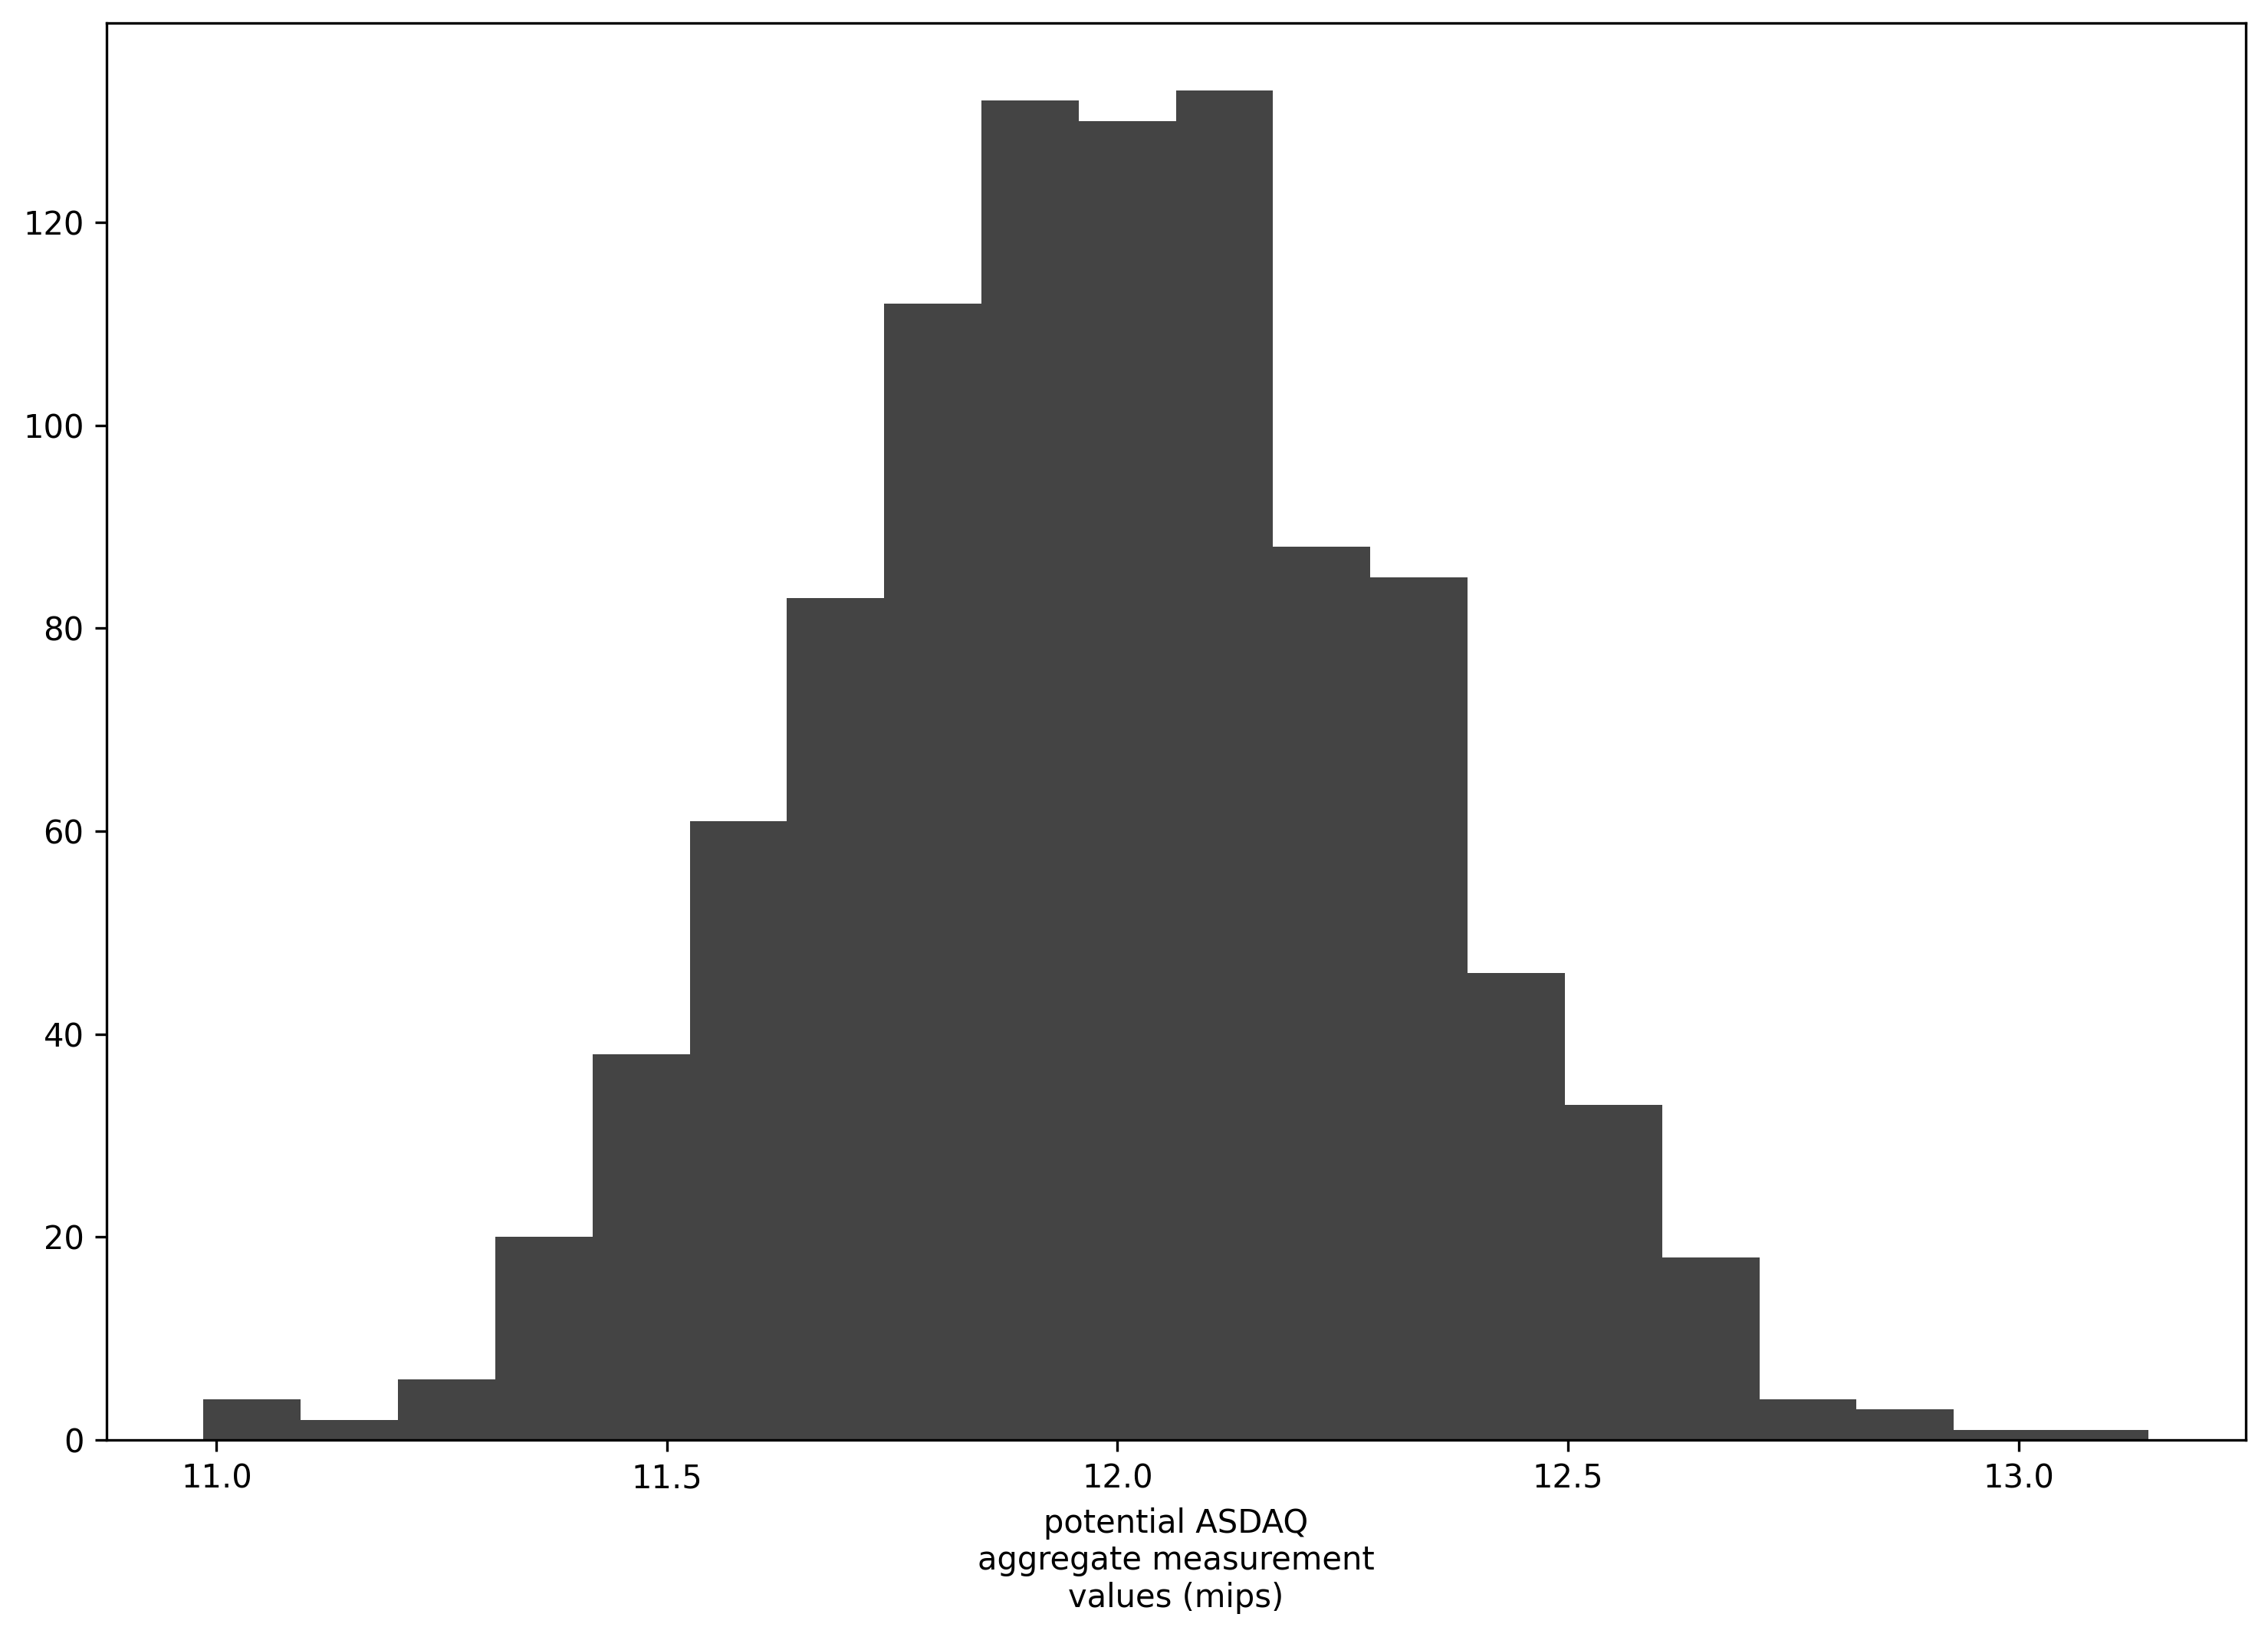

In [34]:
plt.figure(figsize=(12,8))
np.random.seed(17)
plt.hist(
    np.array([aggregate_measurement_with_se("ASDAQ",10)[0] for _ in range(1000)]), # 1000 sample means
    20,
    color=e4e.color_1,
)
plt.xlabel("potential ASDAQ\naggregate measurement\nvalues (mips)")
#e4e.vertical_line(13)
#plt.annotate("actual\naggregate\nmeasurement",xy = [112.3, 90],xytext=[120, 110],arrowprops = e4e.arrow_props)
plt.show()

In [35]:
# Delta, the difference between the aggregate measurement of BYSE and ASDAQ
np.random.seed(17)
num_individual_measurements = 10
agg_asdaq, se_asdaq = aggregate_measurement_with_se("ASDAQ", num_individual_measurements)
agg_byse, se_byse = aggregate_measurement_with_se("BYSE", num_individual_measurements)
delta = agg_byse - agg_asdaq      # if equal, delta is 0; if byse is lower, delta is negative; B-A
se_delta = np.sqrt(se_byse**2 + se_asdaq**2) # independent var(x+y)= var(x) + var(y); σ(x+y) = √var(x+y)

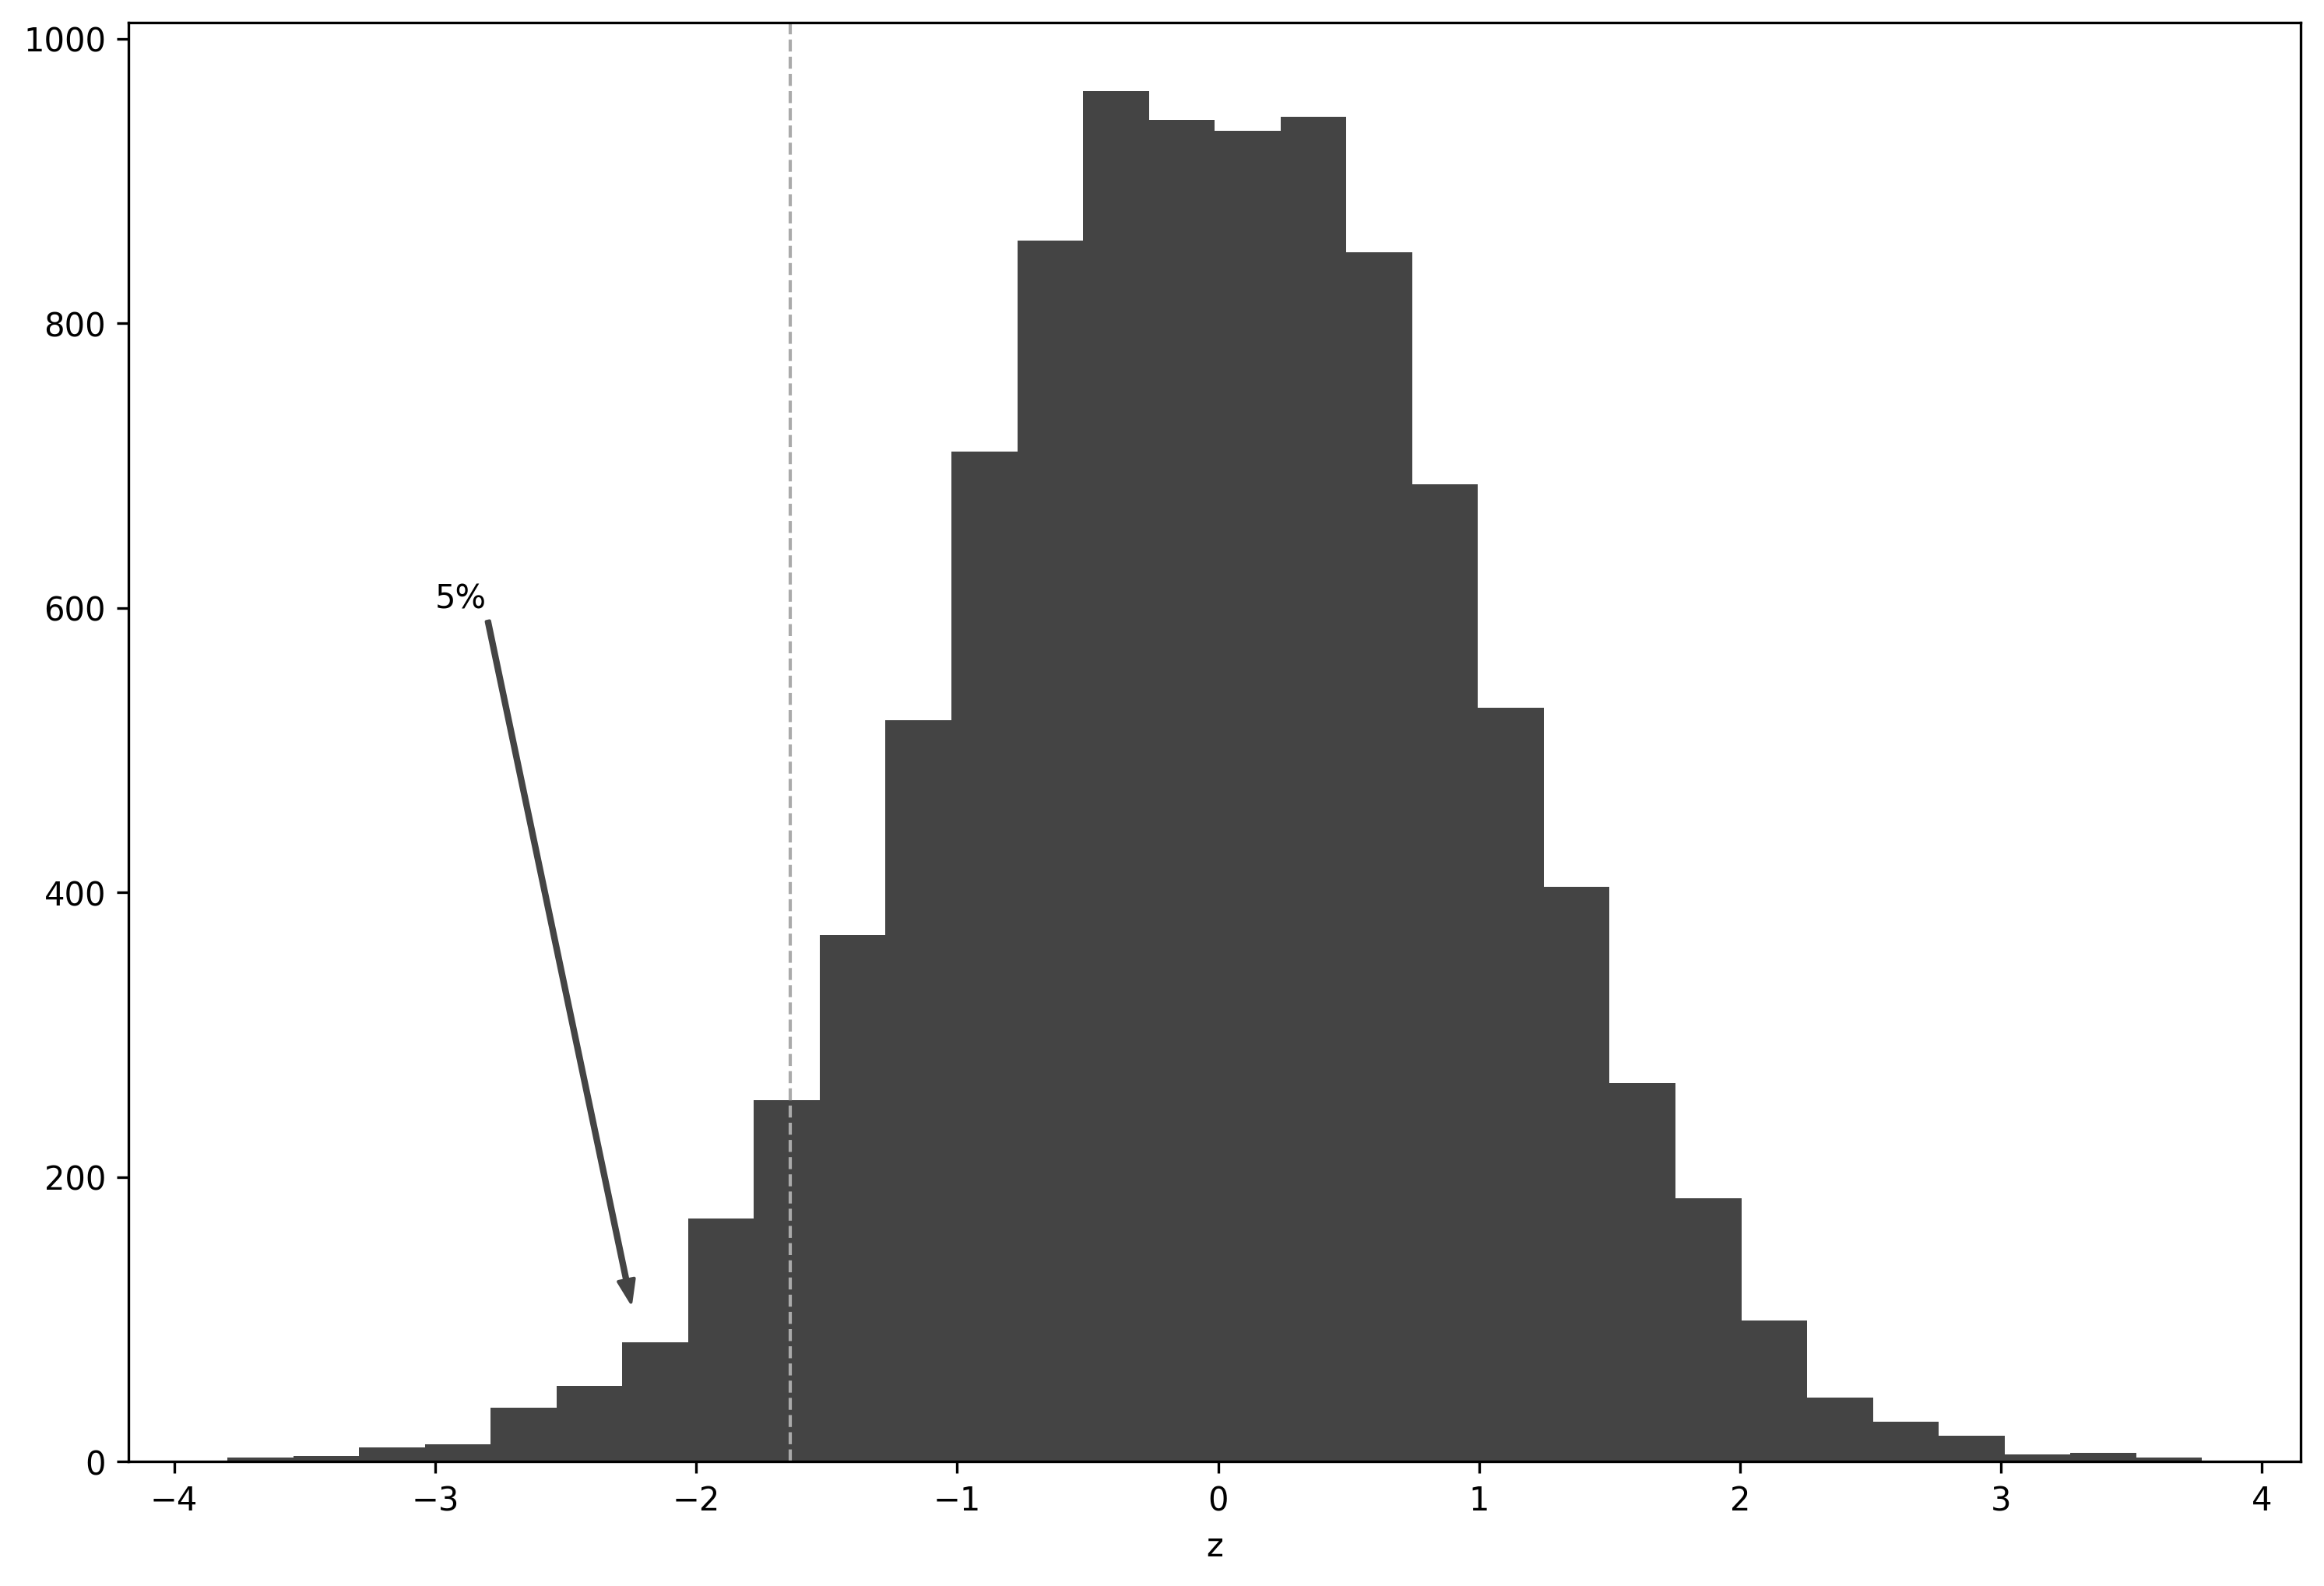

In [36]:
# Z-score, converting delta to standard normal
plt.figure(figsize=(12,8))
z = np.random.normal(size=(10000,))     # 1000 values from standard normal (mean) loc=0.0, (std) scale=1.0
plt.hist(z, 30, color=e4e.color_1)      # histogram of standard normal 
plt.xlabel("z")
e4e.vertical_line(-1.64)                # 5% cdf line, statistical significance for B being lower than A
plt.annotate(text="5%", xy=[-2.25, 112], xytext=[-3,600], 
            arrowprops=e4e.arrow_props) # annotate point xy, with text located at xytext using arrow arrowprops
plt.show()

#### Design the A/B test

In [37]:
# Defining z-score based on the standard deviations instead of standard error
def ab_test_design(sd_1_delta, prac_sig):
    num_individual_measurements = (1.64 * sd_1_delta / prac_sig) ** 2 # ensure z < -1.64 when delta < -prac_sig
    return np.ceil(num_individual_measurements)     # round up to the nearest integer

In [38]:
# pilot study to obtain standard deviations
np.random.seed(17)
sd_1_asdaq = np.array([trading_system("ASDAQ") for _ in range(100)]).std()
sd_1_byse = sd_1_asdaq  # assume both versions share the same variation
sd_1_delta = np.sqrt(sd_1_asdaq**2 + sd_1_byse**2)      # standard deviation of delta
prac_sig = 1        # practical significance level, the amount of improvement we want to see
ab_test_design(sd_1_delta, prac_sig)        # number of individual measurements to take

7.0

#### False negatives

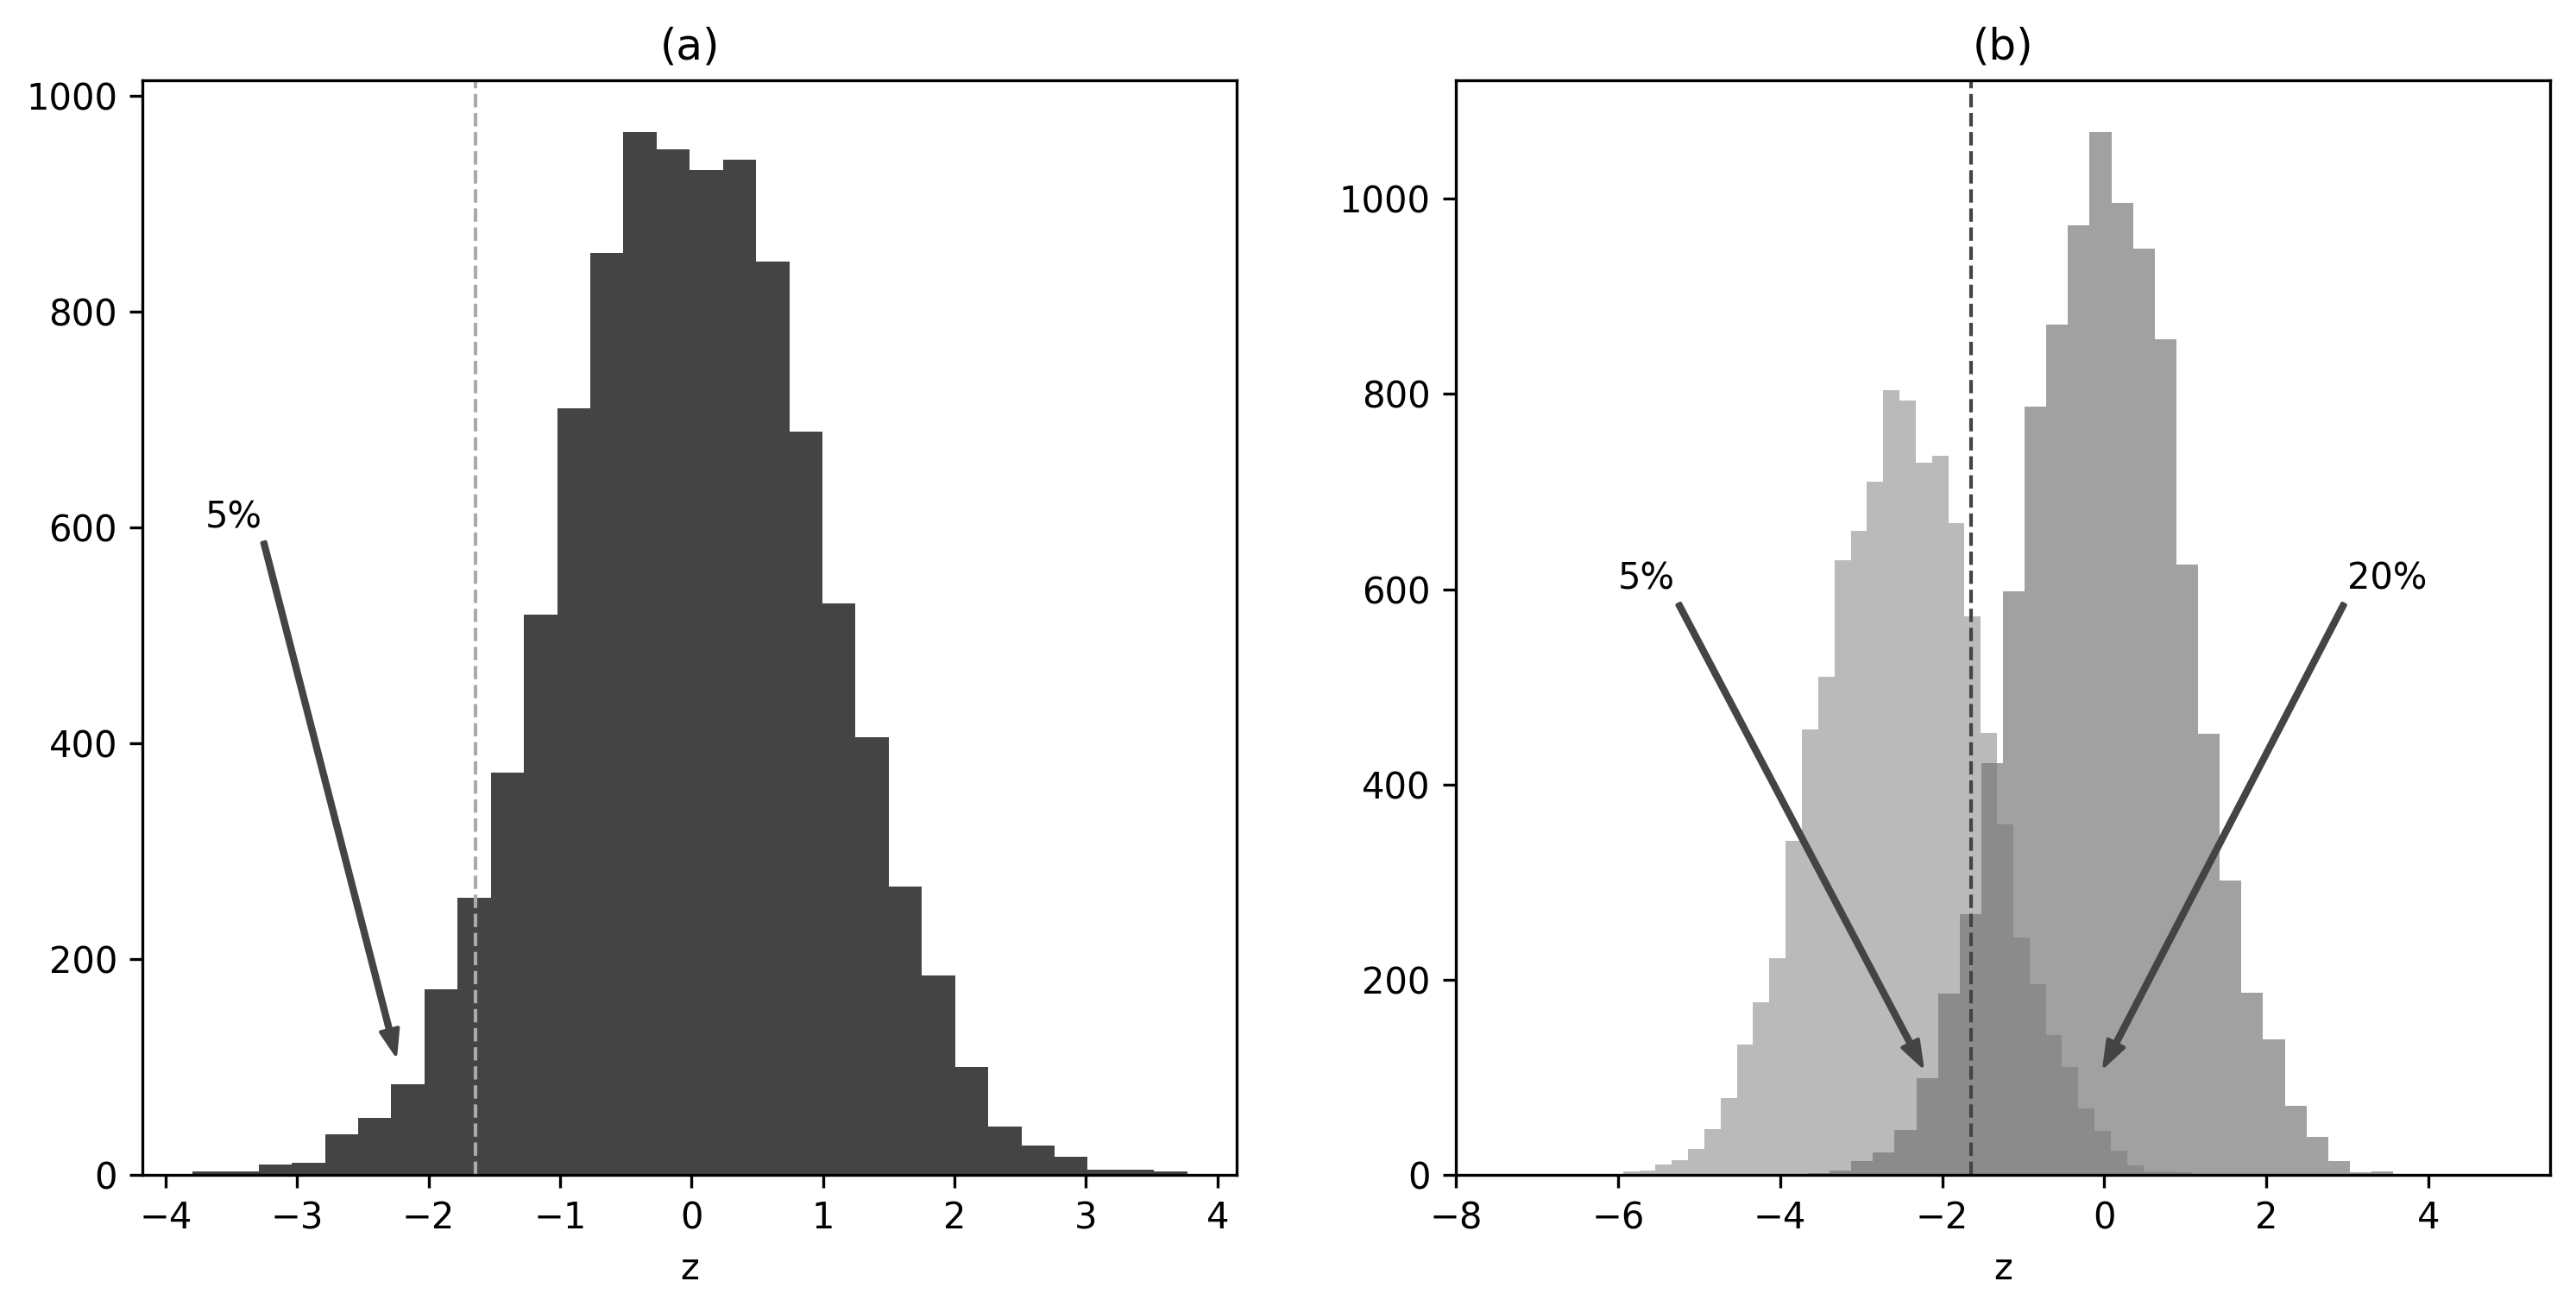

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))


z = np.random.normal(size=(10000,))
ax1.hist(z, 30, color=e4e.color_1)
ax1.set_xlabel("z")
e4e.vertical_line(-1.64, ax=ax1)

ax1.annotate("5%", xy=[-2.25, 112], xytext=[-3.7, 600], arrowprops=e4e.arrow_props)

ax1.set_title("(a)")
e4e.aspect_square(ax1)

z = np.random.normal(size=(10000,))
ax2.hist(z, 30, color=e4e.color_1, alpha=0.5)
ax2.set_xlabel("z")
e4e.vertical_line(-1.64, clr=e4e.color_1, ax=ax2)
ax2.annotate("5%", xy=[-2.25, 112], xytext=[-6, 600], arrowprops=e4e.arrow_props)

ax2.annotate("20%", xy=[0, 112], xytext=[3, 600], arrowprops=e4e.arrow_props)
ax2.hist(-(1.64 + 0.84) + z, 40, color=e4e.color_2, alpha=0.5)
c = ax2.axis()
ax2.axis([-8, 5.5, 0, c[3]])
ax2.set_title("(b)")
e4e.aspect_square(ax2)

plt.show()

In [40]:
# A/B test design with power analysis (consideration of false negatives)
def ab_test_design_2(sd_1_delta, prac_sig):
    num_individual_measurements = (2.48 * sd_1_delta / prac_sig)**2 # includes both fpr and fnr considerations
    return np.ceil(num_individual_measurements)

In [41]:
np.random.seed(17)
sd_1_asdaq = np.array([trading_system("ASDAQ") for _ in range(100)]).std() # pilot study for standard deviation
sd_1_byse = sd_1_asdaq # assume distribution of both versions have same standard deviation
sd_1_delta = np.sqrt(sd_1_asdaq**2 + sd_1_byse**2)  # standard deviation of the change we want to see
prac_sig = 1.0          # the change we want to see
ab_test_design_2(sd_1_delta, prac_sig)

16.0

#### Measure and analyze

In [42]:
def measure(min_individual_measurements):
    ind_asdaq = []
    ind_byse = []
    while (
        len(ind_asdaq) < min_individual_measurements and 
        len(ind_byse) < min_individual_measurements):       # collect at least min_individual_measurements      
        if np.random.randint(2) == 0:                       # randomize to remove confounder bias
            ind_asdaq.append(trading_system("ASDAQ"))
        else:
            ind_byse.append(trading_system("BYSE"))
    return np.array(ind_asdaq), np.array(ind_byse)           # convert from list to ndarray

In [43]:
# collect measurements
np.random.seed(17)
ind_asdaq, ind_byse = measure(16)

In [44]:
# Test one: Measure delta for practical significance
ind_byse.mean() - ind_asdaq.mean()          # delta < -prac_sig. Test for practical significance passed

-2.7483767796620846

In [45]:
# Analyze stage
def analyze(ind_asdaq, ind_byse):
    agg_asdaq = ind_asdaq.mean()                                # A aggregate measurement
    se_asdaq = ind_asdaq.std() / np.sqrt(len(ind_asdaq))        # A standard error
    agg_byse = ind_byse.mean()                                  # B aggregate measurement
    se_byse = ind_byse.std()  / np.sqrt(len(ind_byse))          # B standard error

    delta = agg_byse - agg_asdaq                                # delta of aggregate measurements
    se_delta = np.sqrt(se_asdaq**2 + se_byse**2)                # delta standard error
    z = delta / se_delta                                        # z-score for statistical significance
    return z

In [46]:
# Test two : Measure z-score for statistical significance (false positive rate)
analyze(ind_asdaq, ind_byse)    # delta is statistically significant (less than -1.64). Second test passed

-6.353995237966593